# Comparing Portfolio Optimization Techniques
<sub>**by Aung Si**</sub><br>
<sub>May 5<sup>th</sup>, 2023</sub>

---

#### *Disclaimer*

*I am relatively new to quantitative analysis and the techniques presented in this report may not be comprehensive or fully optimized. The purpose of this analysis is to explore and learn about the concepts and techniques involved in portfolio optimization and is not intended as investment advice or fully-vetted strategies. The results, interpretations, and conclusions drawn from this analysis should be taken with caution.*

---

## Summary
In this paper, I optimized a portfolio of stocks in three ways: **1)** maximizing its Sharpe Ratio (Maximum Sharpe Optimization), **2)** minimizing its volatility (Minimum Variance Optimization), and **3)** equalizing the risk contribution of each asset in the portfolio (Risk Parity Optimization). These optimizations are conducted using our in-sample time period. Finally, I compare the performance of each of the portfolios using an out-of-sample time period and discuss the shortfalls and strengths of each optimization technique.

---

## Introduction
Portfolio optimization is the procedure of fine-tuning an array of potential portfolios to achieve a desired outcome. This involves balancing the risk and return trade-off within these portfolios to select one that most aligns with the investor's specific objectives and risk tolerance. **The Sharpe Ratio**, named after Nobel Laureate William F. Sharpe, is a measure that quantifies the return of an investment relative to its risk, and I use it extensively in this paper to compare the resulting portfolios.

The formula for the Sharpe Ratio is given by:
$$S_p = \frac{E(R_p) - R_f}{\sigma_p}$$
where $E(R_p)$ is the expected or realized returns of the portfolio, $R_f$ is the risk-free rate, and $\sigma_p$ is the standard deviation of the portfolio.

### Portfolio Optimization
When we optimize a portfolio, we are tuning it in hopes of meeting specific investment goal. Do we want to maximize its Sharpe Ratio (thereby assuming higher returns, but necessarily higher risk)? Do we want to wholly minimize the portfolio's risk profile, irrespective of the return tradeoff? Do we want to allocate capital such that the constituent assets all contribute risk equally to the portfolio? 

As an investor, you're at the command center of your investment strategy, and you've got a bunch of knobs and dials in front of you. Each of these controls corresponds to the weight of a particular asset in your portfolio. Your mission is to find the perfect settings for these controls to hit your investment goal.

Portfolio optimization, like any quantitative strategy, relies on historical data. This implies that using the same optimization technique (say, Maximum Sharpe) on the same set of stocks, but with different time periods, can yield different allocations for each stock.

Below are the three optimization techniques studied in this paper, in brief.

### Optimizing for Sharpe Ratio
The Sharpe ratio is defined as the difference between the returns of the investment and the risk-free rate, divided by the standard deviation of the returns. This ratio helps investors understand the return of an investment compared to its risk. The higher the Sharpe ratio, the better the investment's historical risk-adjusted performance.

In portfolio optimization, the "Maximum Sharpe Ratio Portfolio" is the one that provides the highest possible expected return for a defined level of risk, measured by the standard deviation of the portfolio's returns. This portfolio lies on the far left edge of the efficient frontier - the set of optimal portfolios offering the highest expected return for a defined level of risk.

### Optimizing for Minimum Variance
Another approach to portfolio optimization is the "Minimum Variance Portfolio" method. This strategy focuses on minimizing the portfolio's overall risk (variance). The portfolio's risk is calculated based on the covariance matrix of the returns of the assets in the portfolio. This approach is particularly useful for risk-averse investors who want to minimize the risk associated with their investments. Inherent to Minimum Variance Optimization is the return tradeoff that results from assuming less risk (as will be demonstrated later).

### Optimizing for Risk Parity
Risk Parity is another portfolio optimization method that allocates the portfolio's risk equally across all assets. This strategy doesn't aim to maximize returns but to equalize the risk contribution of each asset to the total portfolio risk. This results in a more balanced portfolio, reducing the dependency on a single or a few assets. The logic of Risk Parity Optimization is slightly more complex than Maximum Sharpe and Minimum Variance Optimization, so I'll cover it in more detail later in the paper.

### The Initial Portfolio
In our case, we have a set of tickers from 9 different sectors: Technology, Financial, Healthcare, Consumer, Energy, Industrials, Utilities, Real Estate, and Materials. One ticker is chosen from each sector, totaling 9 tickers in the portfolio. The portfolio will be optimized using the above three methods, ensuring efficient management of risk and aiming for a high return. Our  initial portfolio begins with equal allocations across the stocks:

<br>$$\frac{100\%}{9 \text{ stocks}} = 11.11\% \text{ per stock}$$

### Key Assumptions
- Total absence of transaction costs, fees, and tax (note that accounting for these can significantly impact returns).
- The expected return of each asset is equal to its mean return in the prior period.
- The future will somewhat mimic the past, in terms of risk, return, and asset correlations.
- Investors are rational and avoid risk when possible unless appropriately compensated for taking on additional risk.
- The yield on the 10-year Treasury is equivalent to the risk-free-rate.
- In all portfolios and across the timeframe, we maintain constant relative allocations; there's no rebalancing taking place.

---

## Optimizing the Portfolio

The heart of our optimization processes is the `minimize` function from `scipy.optimize`. This allows us to tune the portfolio based on various objective functions.

In [1]:
import PortOpt as po
import QuantFuncs as q
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from scipy.optimize import minimize
from datetime import datetime

### Constructing the Initial Portfolio

We build our initial portfolio of stocks by choosing one random ticker from each sector provided by the `universe` dictionary in the `quantfuncs` module. `universe` contains indices, but we are only concerned with individual stocks.

In [2]:
# Possible catalogue of tickers.
q.call_universe()

,Technology,Financial,Healthcare,Consumer,Energy,Industrials,Utilities,Real Estate,Materials
#,,,,,,,,,
1,AAPL,JPM,JNJ,WMT,XOM,GE,NEE,SPG,LIN
2,MSFT,BAC,UNH,KO,CVX,HON,DUK,PLD,APD
3,GOOGL,V,PFE,PEP,COP,UNP,SO,EQIX,ECL
4,AMZN,MA,MRK,PG,EOG,MMM,D,EQR,PPG
5,MET,GS,ABT,MCD,PSX,BA,EXC,AVB,NEM
6,TSLA,MS,MDT,NKE,MPC,CAT,AEP,PSA,IFF
7,NVDA,AXP,LLY,SBUX,VLO,DE,SRE,VTR,SHW
8,INTC,WFC,AMGN,MMM,OXY,CSX,XEL,WELL,LYB
9,CSCO,C,GILD,CL,HES,EMR,WEC,CCI,ALB


In [3]:
random.seed(888)

# Building a portfolio consisting of one stock chosen at random from each of the sectors in the universe variable.
u = q.universe.copy()
tickers = []
for sector in u:
    tickers.append(u[sector]['tickers'][random.choice(list(np.arange(0, 10, 1)))])
    
print(f'Chosen portfolio tickers: {tickers}')

Chosen portfolio tickers: ['MSFT', 'AXP', 'VRTX', 'MMM', 'OXY', 'DE', 'AEP', 'CCI', 'SHW']


Using the `random` module, we've chosen the following tickers to constitute the initial portfolio:

1. Microsoft (MSFT) - Technology
2. American Express (AXP) - Financial
3. Vertex Pharmaceuticals (VRTX) - Healthcare
4. 3M Company (MMM) - Industrials
5. Occidental Petroleum (OXY) - Energy
6. Deere & Co. (DE) - Industrials
7. American Electric Power (AEP) - Utilities
8. Crown Castle International (CCI) - Real Estate
9. Sherwin-Williams (SHW) - Materials

**Note that the sector categorizations may not be as clean-cut as presented given the complexities of business and reach of each company.*

### Collecting in-sample data

Our in-sample data serves as the basis for our portfolio optimization. The optimizations are run using this dataset and the resulting portfolios will be tested using the out-of-sample time period in order to avoid forward-looking bias and data-snooping.

We also need a risk-free-rate in order to compute the Sharpe ratios of each optimized portfolio.

In [4]:
# Defining our in-sample and out-of-sample start and end dates.
start_date = '2015-01-01'
in_samp_end_date = '2020-01-01'
end_date = '2023-05-16'

# Fetching in-sample and out-of-sample price data.
price_dict, test_price_dict = q.fetch_and_split_price_data(tickers, start=start_date, end=end_date, insamp_end=in_samp_end_date)
price_df = pd.DataFrame.from_dict(price_dict)

# In-sample return data.
returns_df = np.log(price_df).diff()[1:]

# Risk-free rate.
rfr = (q.get_pricing('^TNX', start=start_date, end=in_samp_end_date)/100).iloc[-1]

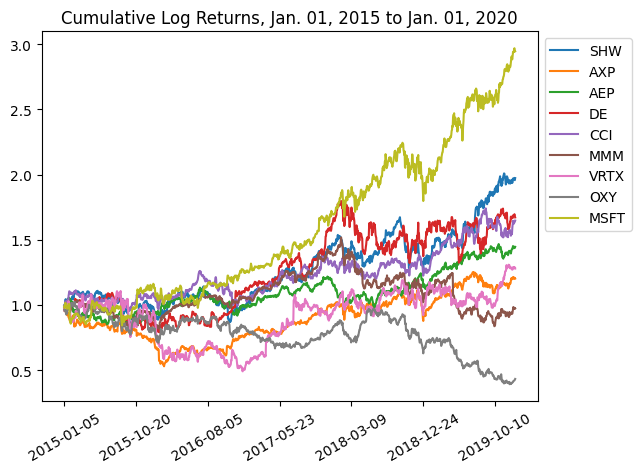

In [5]:
format = '%Y-%m-%d'
n_format = '%b. %d, %Y'
s = datetime.strptime(start_date, format).strftime(n_format)
i = datetime.strptime(in_samp_end_date, format).strftime(n_format)
e = datetime.strptime(end_date, format).strftime(n_format)

# Plot the cumulative returns to get a sense of each stock's performance.
np.cumprod(1 + returns_df).plot()
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=30)
plt.title(f'Cumulative Log Returns, {s} to {i}')
plt.xlabel('');

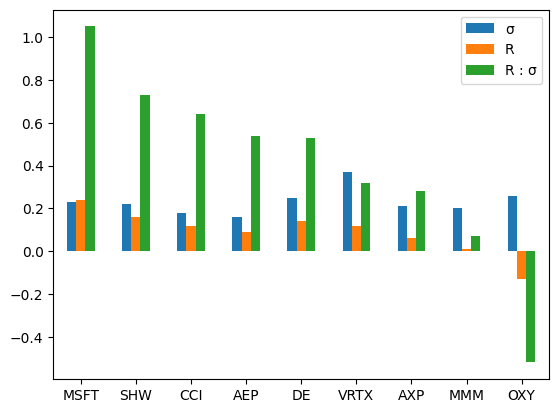

In [6]:
# Compute the annual volatility of each stock.
annualized_volatilities = np.sqrt(np.var(returns_df) * 252)

# Compute the annual mean returns of each stock.
annualized_returns = np.mean(returns_df, axis=0) * 252

# Display the risk/return profiles of each stock in a dataframe.
stats_df = pd.DataFrame({
    'σ': round(annualized_volatilities, 2),
    'R': round(annualized_returns, 2),
    'R : σ': round(annualized_returns/annualized_volatilities, 2)
})

# Reward-risk comparison.
sorted_stats_df = stats_df.sort_values(by='R : σ', ascending=False)
sorted_stats_df.plot.bar()
plt.xticks(rotation=0);

### Checking Asset Correlations

When constructing a well-diversified portfolio, it's generally desirable to have a portfolio of lowly-correlated / uncorrelated stocks. This allows the investor to own assets that perform differently in different economic scenarios, with certain assets' outperformance countering the drawdowns resulting from other assets' underperformance.

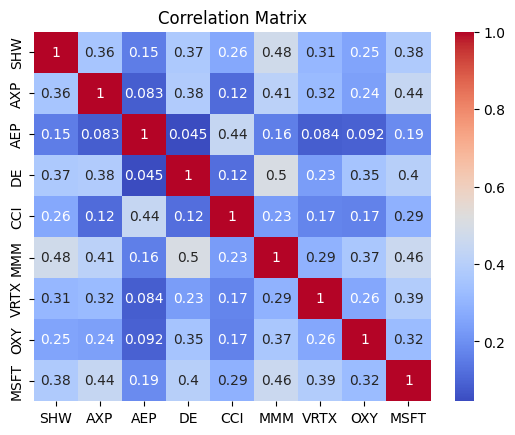

In [7]:
# Plot correlation heatmap, which is more visually informative than an array/dataframe.
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.grid(False);

In our correlation matrix, we see that the assets within the portfolio generally exhibit low, positive correlation. Low, positive correlation signifies that the assets generally move in the same direction but not always to the same extent. This indicates that there is at least a degree of diversification within our initial portfolio.

### Creating an Equal-Weight Portfolio

We initialize a portfolio of stocks that hold equal weights within the portfolio. This is done in order to have a starting point for comparison with our optimized portfolios and to illustrate the benefits of portfolio optimization. The weights also serve as initial guesses for our optimization functions.

In [8]:
# Create an Equal-Weight Portfolio.
num_assets = len(tickers)
ew_port = np.ones(num_assets) / num_assets

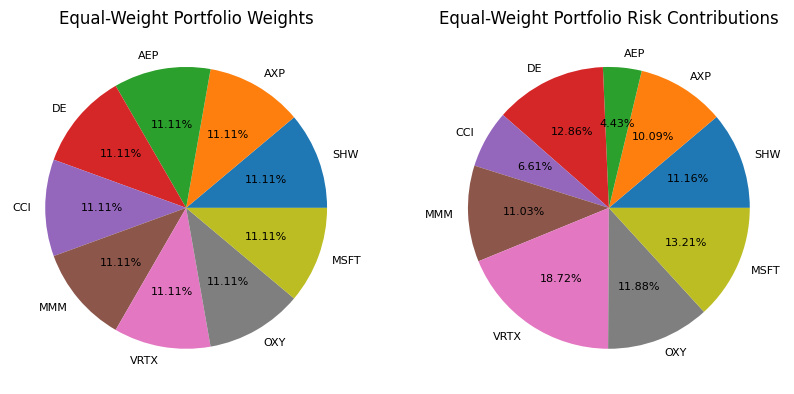

In [9]:
# Plot the weights and risk contributions of the stocks in the Equal-Weight Portfolio
fig, axs = plt.subplots(1, 2, figsize=(10,10))
ew_port_weights = po.prune(ew_port, returns_df, price_df, type='weights')
ew_port_risk_conts = po.prune(ew_port, returns_df, price_df, type='risk')
axs[0].pie(ew_port_weights[0], labels=ew_port_weights[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[1].pie(ew_port_risk_conts[0], labels=ew_port_risk_conts[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[0].set_title('Equal-Weight Portfolio Weights')
axs[1].set_title('Equal-Weight Portfolio Risk Contributions');

In the in-sample timeframe, Vertex Pharmaceuticals (VRTX) seems to contribute the most risk to the portfolio, with the smallest contributor being American Electric Power (AEP).

In [10]:
# Display equal-weight portfolio stats.
ew_port_ret = po.port_return(ew_port, returns_df, name='Equal-Weight')
ew_port_risk = po.port_risk(ew_port, returns_df, name='Equal-Weight')
ew_port_sharpe = po.sharpe(ew_port, returns_df, rfr, name='Equal-Weight')

Annual Expected Return of Equal-Weight Portfolio: 8.85%
Annual Risk of Equal-Weight Portfolio: 14.05%
Annual Sharpe Ratio of Equal-Weight Portfolio: 0.49


A Sharpe Ratio of 0.49 may tell us that we are not being compensated well enough for the risk we are taking on through our initial portfolio. However, a Sharpe Ratio by itself is also not descriptive beyond a comparison against the risk-free-rate; comparing multiple Sharpe Ratios gives us a much better picture of the available options and their respective risk-adjusted historical performance. Later, we will see how these numbers drastically change as we run our optimizations on it.

### Maximum Sharpe Optimization

Now, we optimize to maximize the Sharpe Ratio of the portfolio. Recall that the higher the Sharpe ratio, the better the investment's historical risk-adjusted performance.

We first define the bounds and constraints for the optimization problem. The bounds variable is a list of tuples that specify the lower and upper bounds for each asset's weight in the portfolio - in this case, between 0 and 1, meaning no short selling is allowed and no leverage is used. The constraints variable is a dictionary that specifies an equality constraint - the function should return 0 when the sum of the portfolio weights equals 1, ensuring that the total allocation of our portfolio sums up to 100%

In [11]:
# Define bounds and constraints (applies to all optimizations).
bounds = num_assets * [(0, 1)]
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

In [12]:
# Run Maximum Sharpe Optimization.
# Maximizing the Sharpe ratio means we minimize the negative of the Sharpe Ratio.
ms_opt = minimize(
    lambda w: -po.sharpe(w, returns_df, rfr, verbose=False), 
    ew_port,
    bounds=bounds,
    constraints=constraints
)

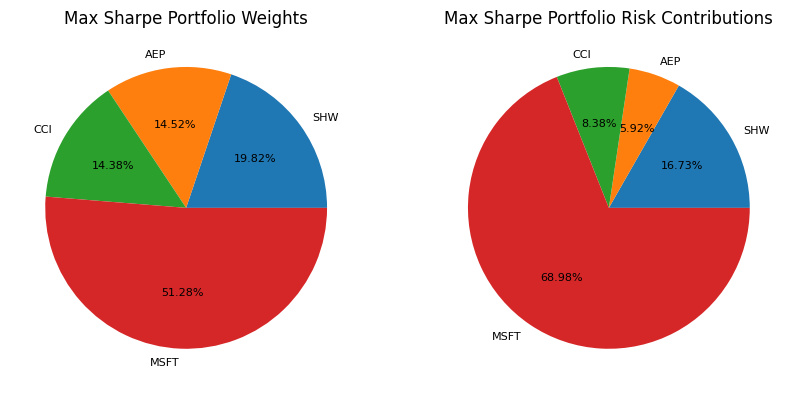

In [13]:
# Store Max Sharpe Portfolio weights in variable.
ms_port = ms_opt.x

# Plot weights and risk contributions of the stocks within the Maximum Sharpe Portfolio.
fig, axs = plt.subplots(1, 2, figsize=(10,10))
ms_port_weights = po.prune(ms_port, returns_df, price_df, type='weights')
ms_port_risk_conts = po.prune(ms_port, returns_df, price_df, type='risk')
axs[0].pie(ms_port_weights[0], labels=ms_port_weights[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[1].pie(ms_port_risk_conts[0], labels=ms_port_risk_conts[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[0].set_title('Max Sharpe Portfolio Weights')
axs[1].set_title('Max Sharpe Portfolio Risk Contributions');

After optimizing to achieve the Maximum Sharpe Ratio, we see that the algorithm only kept 4 out of 9 stocks, with Microsoft taking the lion's share of our allocation. Microsoft also contributes the most risk to the portfolio, and American Electric Power the least.

In [14]:
# Compute the returns, risk, and Sharpe Ratio for the Maximum Sharpe Portfolio.
ms_port_ret = po.port_return(ms_port, returns_df, name='Max-Sharpe')
ms_port_risk = po.port_risk(ms_port, returns_df, name='Max-Sharpe')
ms_port_sharpe = po.sharpe(ms_port, returns_df, rfr, name='Max-Sharpe')

Annual Expected Return of Max-Sharpe Portfolio: 18.57%
Annual Risk of Max-Sharpe Portfolio: 15.95%
Annual Sharpe Ratio of Max-Sharpe Portfolio: 1.04


After optimizing our portfolio to maximize its Sharpe Ratio, we see that we've bumped up its historical returns significantly. We also see that its risk has increased, meaning we are indeed taking on more risk through this optimization process. However, since we are optimizing for its Sharpe Ratio, we are less concerned with the additional risk itself and more with how much more we are being compensated for that additional risk - in our particular case, we've achieved a much higher return for relatively less additional risk taken on.

### Minimum Variance Optimization

Now, we optimize to minimize the overall risk of the portfolio. This follows a similar process as the Maximum Sharpe approach, with the only difference being that we minimize $\sigma_p$ as opposed to the negative of the Sharpe Ratio.

In [15]:
# Run Minimum Variance Optimization.
mv_opt = minimize(
    lambda w: po.port_risk(w, returns_df, verbose=False),
    ew_port,
    bounds=bounds,
    constraints=constraints
)

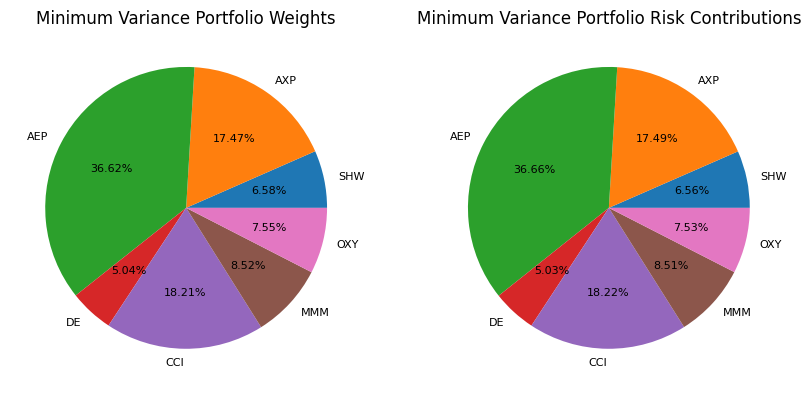

In [16]:
# Store Minimum Variance Portfolio weights in variable.
mv_port = mv_opt.x

# Plot weights and risk contributions of the stocks within the Minimum Variance Portfolio.
fig, axs = plt.subplots(1, 2, figsize=(10,10))
mv_port_weights = po.prune(mv_port, returns_df, price_df, type='weights')
mv_port_risk_conts = po.prune(mv_port, returns_df, price_df, type='risk')
axs[0].pie(mv_port_weights[0], labels=mv_port_weights[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[1].pie(mv_port_risk_conts[0], labels=mv_port_risk_conts[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[0].set_title('Minimum Variance Portfolio Weights')
axs[1].set_title('Minimum Variance Portfolio Risk Contributions');

The pie charts for the Minimum Variance Portfolio Weights and Risk Contributions look very similar. This is an expected outcome. In a minimum variance portfolio, the optimization process is set up to minimize the portfolio's overall variance. To achieve this, the algorithm adjusts the weights of the assets in a way that the risk contribution of each asset is roughly proportional to its weight in the portfolio. This is why the weights and the risk contributions of the assets appear similar when plotted. However, it's important to note that this might not always be the case depending on the specific variances and correlations of the assets in the portfolio.

In [17]:
# Compute the returns, risk, and Sharpe Ratio for the Minimum Variance Portfolio.
mv_port_ret = po.port_return(mv_port, returns_df, name='Minimum-Variance')
mv_port_risk = po.port_risk(mv_port, returns_df, name='Minimum-Variance')
mv_port_sharpe = po.sharpe(mv_port, returns_df, rfr, name='Minimum-Variance')

Annual Expected Return of Minimum-Variance Portfolio: 7.18%
Annual Risk of Minimum-Variance Portfolio: 11.72%
Annual Sharpe Ratio of Minimum-Variance Portfolio: 0.45


Through Minimum Variance Optimization, our portfolio's Sharpe Ratio decreased by 0.07. This decline signifies that while our portfolio's risk exposure has indeed diminished, the accompanying reduction in expected returns was proportionally greater (although by not much), resulting in a less favourable risk-to-reward ratio as captured by the Sharpe Ratio.

This scenario highlights the fundamental interplay between risk and return in portfolio optimization. By tailoring our portfolio to minimize risk, we inadvertently accepted a reduction in expected returns that outweighed the benefits of lower risk, thereby leading to a lower Sharpe Ratio.

### Risk Parity Optimization

Risk Parity Optimization, i.e. optimizing to equalize the risk contributions of each asset in the stock, is not as straight forward as the prior two optimization processes. The goal of Risk Parity Optimization is to find a portfolio weight vector $\mathbf{w} = (w_1, w_2, \dots, w_n)^T$ such that the risk contribution of each asset in the portfolio is equal. Since we have 9 assets, we'd expect a risk contribution of about 11.11% from each stock. 

Mathematically, we aim to minimize the following objective function:

$$\text{Objective Function }=\sum_{i=1}^{N} \left( RC_i - \frac{1}{N} \right)^2$$
 

where $RC_i$ is the risk contribution of the $i$-th asset, which can be calculated as:

$$RC_i = \frac{w_i \sum_{j=1}^{N} w_j \text{Cov}(R_i, R_j)}{\sigma^2_p}$$
$$\text{where}$$
$$\sigma^2_p = \sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j \text{Cov}(R_i, R_j)$$

An individual asset's risk contribution is not simply its variance as a proportion of the portfolio's total variance as this would ignore its interaction with other assets in the portfolio, as well as the diversification effects that arise from these interactions.

In a portfolio context, assets do not exist in isolation. Their returns are often correlated to some extent, meaning that the price movements of one asset can influence the price movements of another. These correlations are captured by the covariance matrix, which gives a measure of how much two assets' returns move together.

When calculating the risk contribution of an individual asset, we need to take into account not only the asset's own risk (as measured by its variance), but also its covariances with all the other assets in the portfolio. This is done by calculating a weighted sum of covariances, where each covariance is multiplied by the weight of the corresponding asset in the portfolio.

This approach captures the fact that an asset can contribute to the portfolio's risk not only through its own volatility, but also through its interactions with other assets. If an asset is highly correlated with another volatile asset, it can amplify the portfolio's overall risk. Conversely, if it's negatively correlated with another volatile asset, it can help to reduce the portfolio's risk through diversification.*

**The variance formula is explained in more detail in the Appendix.*

In [18]:
# Run Risk Parity Optimization.
rp_opt = minimize(
    lambda w: po.risk_parity(w, returns_df, num_assets),
    ew_port,
    bounds=bounds,
    constraints=constraints
)

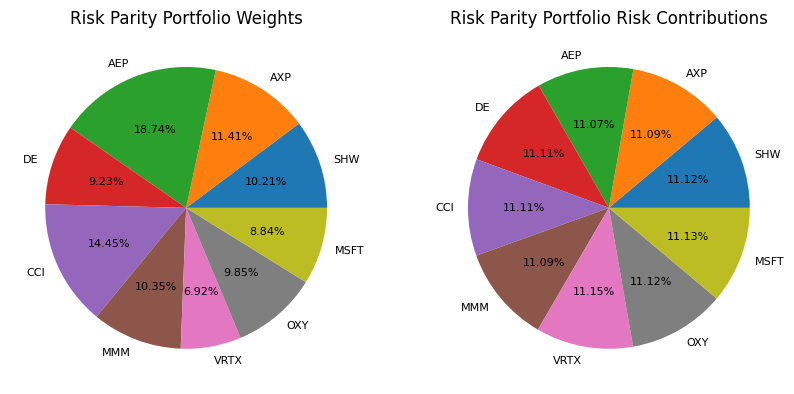

In [19]:
# Store Risk Parity Portfolio weights in variable.
rp_port = rp_opt.x

# Plot weights and risk contributions of the stocks within the Risk Parity Portfolio.
fig, axs = plt.subplots(1, 2, figsize=(10,10))
rp_port_weights = po.prune(rp_port, returns_df, price_df, type='weights')
rp_port_risk_conts = po.prune(rp_port, returns_df, price_df, type='risk')
axs[0].pie(rp_port_weights[0], labels=rp_port_weights[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[1].pie(rp_port_risk_conts[0], labels=rp_port_risk_conts[1], autopct='%.2f%%', textprops={'fontsize': 8})
axs[0].set_title('Risk Parity Portfolio Weights')
axs[1].set_title('Risk Parity Portfolio Risk Contributions');

The risk contributions of each asset is roughly the same, which means that our optimization correctly equalized each stock's risk contribution to the portfolio.

In [20]:
# Compute the returns, risk, and Sharpe Ratio for the Risk Parity Portfolio.
rp_port_ret = po.port_return(rp_port, returns_df, name='Risk Parity')
rp_port_risk = po.port_risk(rp_port, returns_df, name='Risk Parity')
rp_port_sharpe = po.sharpe(rp_port, returns_df, rfr, name='Risk Parity')

Annual Expected Return of Risk Parity Portfolio: 8.65%
Annual Risk of Risk Parity Portfolio: 12.87%
Annual Sharpe Ratio of Risk Parity Portfolio: 0.52


Equalizing the risk contribution of each stock bumped the Sharpe Ratio by a small amount - the risk isn't down to the level of the minimum variance portfolio, but the additional returns are relatively higher. Next, I'll directly compare the four portfolios' performance throughout the in-sample dataset.

---

## Performance Comparison and the Efficient Frontier

### Comparing the Portfolios with Each Other and the Benchmark

To accurately assess our portfolios' performance, we'll introduce a benchmark index, specifically, the S&P 500. This widely recognized market standard serves as a proxy for the overall U.S. stock market. Through juxtaposing our strategies with this index, we can effectively contextualize our performance. This comparison lets us gauge whether our investment strategies outperform a passive, diversified U.S. market portfolio, thereby highlighting the value added by our active management strategies.

In [21]:
# Create a Benchmark Portfolio of just the S&P 500.
bm_ticker = ['SPY']
bm_num_assets = len(bm_ticker)
bm_port = np.ones(bm_num_assets) / bm_num_assets
bm_price_dict, test_bm_price_dict = q.fetch_and_split_price_data(bm_ticker, start=start_date, end=end_date, insamp_end=in_samp_end_date)
bm_price_df = pd.DataFrame.from_dict(bm_price_dict)
bm_returns_df = np.log(bm_price_df).diff()[1:]

In [22]:
# Compute the returns, risk, and Sharpe Ratio for the Benchmark Portfolio.
bm_returns = po.port_return(bm_port, bm_returns_df, 'Benchmark')
bm_risk = po.port_risk(bm_port, bm_returns_df, 'Benchmark')
bm_sharpe = po.sharpe(bm_port, bm_returns_df, rfr, 'Benchmark')

Annual Expected Return of Benchmark Portfolio: 9.00%
Annual Risk of Benchmark Portfolio: 13.54%
Annual Sharpe Ratio of Benchmark Portfolio: 0.52


In [23]:
# Compute the total returns of each portfolio.
ew_port_totret = po.total_return(ew_port, price_df, 'Equal-Weight')
ms_port_totret = po.total_return(ms_port, price_df, 'Max Sharpe')
mv_port_totret = po.total_return(mv_port, price_df, 'Minimum Variance')
rp_port_totret = po.total_return(rp_port, price_df, 'Risk Parity')
bm_port_totret = po.total_return(bm_port, bm_price_df, 'Benchmark')

Total Return of Equal-Weight Portfolio: 60.58%
Total Return of Max Sharpe Portfolio: 148.47%
Total Return of Minimum Variance Portfolio: 46.19%
Total Return of Risk Parity Portfolio: 58.37%
Total Return of Benchmark Portfolio: 56.68%


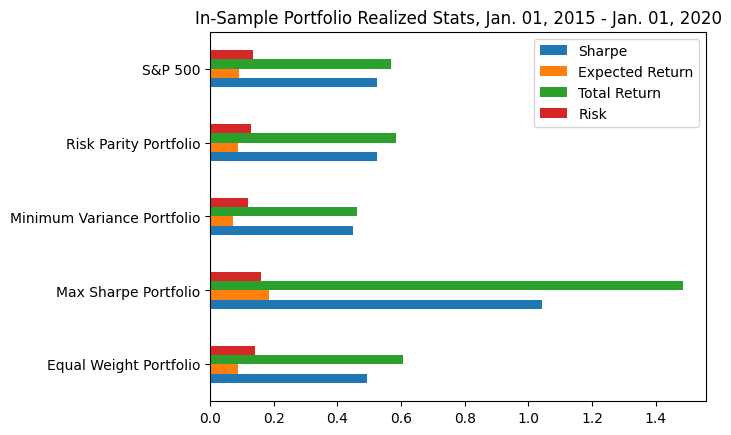

In [24]:
# Create a dataframe consisting of the different portfolios' metrics.
index = ['Equal Weight Portfolio', 'Max Sharpe Portfolio', 'Minimum Variance Portfolio', 'Risk Parity Portfolio']
sharpes = [ew_port_sharpe, ms_port_sharpe, mv_port_sharpe, rp_port_sharpe]
returns = [ew_port_ret, ms_port_ret, mv_port_ret, rp_port_ret]
totrets = [ew_port_totret, ms_port_totret, mv_port_totret, rp_port_totret]
risks = [ew_port_risk, ms_port_risk, mv_port_risk, rp_port_risk]

port_stats = pd.DataFrame({
        'Sharpe': sharpes + [bm_sharpe],
        'Expected Return': returns + [bm_returns],
        'Total Return': totrets + [bm_port_totret],
        'Risk': risks + [bm_risk]},
    index = index + ['S&P 500'])

# Plot the dataframe.
port_stats.plot.barh()
plt.title(f'In-Sample Portfolio Realized Stats, {s} - {i}')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=0);

In our four portfolios, the Max Sharpe Portfolio seems to have the highest risk-adjusted return (which isn't surprising, as a high Sharpe is itself indicative of a high risk-adjusted return). It's also notable that the risk we've assumed in the Max Sharpe portfolio is not much higher than the second riskiest portfolio, the Equally-Weighted portfolio. Out of all the options, Minimum Variance yielded the lowest return, for a risk profile not much lower than the rest.

### The Efficient Frontier

Now let's see where they each stand relative to the efficient frontier. Plotting the portfolios on the efficient frontier provides a graphic demonstration of each portfolio's risk and return trade-off, positioning it in comparison to the theoretically optimal portfolios. These optimal portfolios form the **efficient frontier** - a curve representing combinations of investments that yield the highest expected return for a defined level of risk.

Each point on the frontier signifies an optimal portfolio; a portfolio lying on the frontier signifies that it's efficiently managed, offering the best possible return for its level of risk. Conversely, a portfolio within the frontier could achieve either higher returns with the same risk or the same returns with less risk. Therefore, the closer a portfolio is to the frontier, the better its risk-return trade-off.

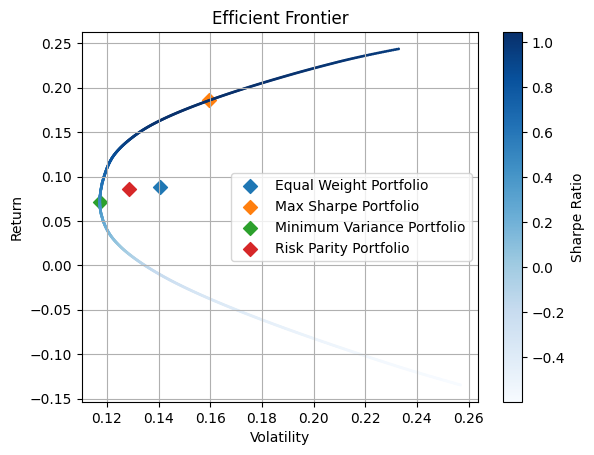

In [25]:
# Plot the portfolios along the efficient frontier.
po.efficient_frontier(returns_df, port_stats, rfr, index)

The Maximum Sharpe portfolio is on the top line of the efficient frontier because this point maximizes the trade-off between risk and return (it's the highest possible return per unit of risk). The Minimum Variance portfolio is at the leftmost point of the efficient frontier because it minimizes risk, regardless of return. The Equal Weight and Risk Parity portfolios are located within the frontier, suggesting that they offer a trade-off between risk and return that's not as efficient as the Maximum Sharpe or Minimum Variance portfolios.

Remember that the performance comparison is only within our in-sample dataset. To really test the viability of each portfolio, we have to run the portfolios through our out-of-sample dataset, which we do below.

---

## Out-of-Sample Performance Test

To see if our portfolios held up according to their optimizations, we need to test them on out-of-sample data.

In [26]:
# Create dataframes of price and return data in the test period for the portfolios.
test_price_df = pd.DataFrame(test_price_dict)
test_returns_df = np.log(test_price_df).diff()[1:]
test_bm_price_df = pd.DataFrame(test_bm_price_dict)
test_bm_returns_df = np.log(test_bm_price_df).diff()[1:]

In [27]:
# Compute total returns for the portfolios in the test period.
test_ew_port_totret = po.total_return(ew_port, test_price_df, name='Equal-Weight')
test_ms_port_totret = po.total_return(ms_port, test_price_df, name='Max Sharpe')
test_mv_port_totret = po.total_return(mv_port, test_price_df, name='Minimum Variance')
test_rp_port_totret = po.total_return(rp_port, test_price_df, name='Risk Parity')
test_bm_port_totret = po.total_return(bm_port, test_bm_price_df, name='Benchmark')

Total Return of Equal-Weight Portfolio: 31.16%
Total Return of Max Sharpe Portfolio: 51.62%
Total Return of Minimum Variance Portfolio: 1.73%
Total Return of Risk Parity Portfolio: 23.29%
Total Return of Benchmark Portfolio: 26.28%


In [28]:
# Compute expected returns for the portfolios in the test period.
test_ew_port_ret = po.port_return(ew_port, test_returns_df, name='Equal-Weight')
test_ms_port_ret = po.port_return(ms_port, test_returns_df, name='Max Sharpe')
test_mv_port_ret = po.port_return(mv_port, test_returns_df, name='Minimum Variance')
test_rp_port_ret = po.port_return(rp_port, test_returns_df, name='Risk Parity')
test_bm_port_ret = po.port_return(bm_port, test_bm_returns_df, name='Benchmark')

Annual Expected Return of Equal-Weight Portfolio: 5.14%
Annual Expected Return of Max Sharpe Portfolio: 9.84%
Annual Expected Return of Minimum Variance Portfolio: -0.55%
Annual Expected Return of Risk Parity Portfolio: 3.35%
Annual Expected Return of Benchmark Portfolio: 6.93%


In [29]:
# Compute risks for the portfolios in the test period.
test_ew_port_risk = po.port_risk(ew_port, test_returns_df, name='Equal-Weight')
test_ms_port_risk = po.port_risk(ms_port, test_returns_df, name='Max Sharpe')
test_mv_port_risk = po.port_risk(mv_port, test_returns_df, name='Minimum Variance')
test_rp_port_risk = po.port_risk(rp_port, test_returns_df, name='Risk Parity')
test_bm_port_risk = po.port_risk(bm_port, test_bm_returns_df, name='Benchmark')

Annual Risk of Equal-Weight Portfolio: 26.64%
Annual Risk of Max Sharpe Portfolio: 27.11%
Annual Risk of Minimum Variance Portfolio: 26.00%
Annual Risk of Risk Parity Portfolio: 25.96%
Annual Risk of Benchmark Portfolio: 24.32%


In [30]:
# Retrieve the test-period risk-free rate.
test_rfr = (q.get_pricing('^TNX', start=in_samp_end_date, end=end_date)/100).iloc[-1]

# Compute Sharpes for the portfolios in the test period.
test_ew_port_sharpe = po.sharpe(ew_port, test_returns_df, test_rfr, name='Equal-Weight')
test_ms_port_sharpe = po.sharpe(ms_port, test_returns_df, test_rfr, name='Max Sharpe')
test_mv_port_sharpe = po.sharpe(mv_port, test_returns_df, test_rfr, name='Minimum Variance')
test_rp_port_sharpe = po.sharpe(rp_port, test_returns_df, test_rfr, name='Risk Parity')
test_bm_port_sharpe = po.sharpe(bm_port, test_bm_returns_df, test_rfr, name='Benchmark')

Annual Sharpe Ratio of Equal-Weight Portfolio: 0.06
Annual Sharpe Ratio of Max Sharpe Portfolio: 0.23
Annual Sharpe Ratio of Minimum Variance Portfolio: -0.16
Annual Sharpe Ratio of Risk Parity Portfolio: -0.01
Annual Sharpe Ratio of Benchmark Portfolio: 0.14


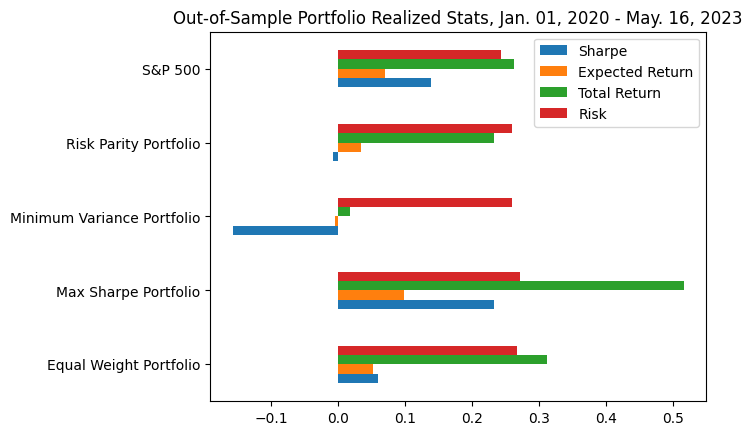

In [31]:
# Create a dataframe consisting of the different portfolios' metrics in the test period.
test_sharpes = [test_ew_port_sharpe, test_ms_port_sharpe, test_mv_port_sharpe, test_rp_port_sharpe]
test_rets = [test_ew_port_ret, test_ms_port_ret, test_mv_port_ret, test_rp_port_ret]
test_totrets = [test_ew_port_totret, test_ms_port_totret, test_mv_port_totret, test_rp_port_totret]
test_risks = [test_ew_port_risk, test_ms_port_risk, test_mv_port_risk, test_rp_port_risk]

test_port_stats = pd.DataFrame({
        'Sharpe': test_sharpes + [test_bm_port_sharpe],
        'Expected Return': test_rets + [test_bm_port_ret],
        'Total Return': test_totrets + [test_bm_port_totret],
        'Risk': test_risks + [test_bm_port_risk]},
    index = index + ['S&P 500'])

# Plot the test period dataframe.
test_port_stats.plot.barh()
plt.title(f'Out-of-Sample Portfolio Realized Stats, {i} - {e}')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=0);

The Maximum Sharpe Portfolio has outperformed all other portfolios in terms of returns. Even when looking at the risk profiles of each portfolio, the Maximum Sharpe Portfolio, though with the highest risk, does not seem to have much more risk than the others. It's important to note that our out-of-sample timeframe is one littered with unforeseen economic dynamics - and therefore, volatility - resulting from the pandemic and its aftermath. It's less surprising then that the risk profiles of all the portfolios we've studied share similar risk profiles, regardless of the optimization metric. What's also notable is that even though we maximized the portfolio for the highest possible Sharpe Ratio, its Sharpe Ratio at the end of the out-of-sample dataset decreased significantly.

The out-of-sample test provided some valuable insights into the adaptability and resilience of our portfolio strategies in the face of real-world market turbulence. While the Maximum Sharpe Portfolio presented impressive returns and managed its risk admirably in the face of challenging market conditions, it's important to remember that this strategy, like all others, is not immune to the fluctuations of the market. Its Sharpe Ratio reduction in the out-of-sample period serves as a potent reminder that no strategy can fully escape the uncertainties of the financial markets. The ability of a portfolio to adapt and perform well during unanticipated market changes is critical for long-term success, and it's clear that the Maximum Sharpe Portfolio has demonstrated this ability to an extent.

However, the ultimate effectiveness of a strategy should be evaluated over multiple market cycles and against a variety of macroeconomic scenarios. This makes it vital to continually assess and adjust our portfolio strategies in line with evolving market conditions. That being said, the Maximum Sharpe Portfolio has shown itself to be a robust strategy during the time period we've studied, and its performance merits further investigation and consideration.

---

## Discussion

Based on the different portfolios' performance in the out-of-sample period, we can begin to understand in which situations each of them may be worth considering, and in which situations each of them may underperform. Below, I discuss some strengths and weaknesses of each of the optimized portfolios.

| Strategy | Strengths | Weaknesses |
| --- | --- | --- |
| Equal Weight Portfolio | Simple to understand and implement. Ensures broad exposure and doesn't allow one asset to dominate the portfolio. | Doesn't take into account the risk and return characteristics of the individual assets. Could be riskier than desired. |
| Maximum Sharpe Portfolio | Uses both the return and risk characteristics of the assets. Identifies the portfolio that provides the maximum 'bang for your buck'. | Relies on accurate estimates of return and risk. Could be sub-optimal if estimates are inaccurate. Tends to be sensitive to changes in the input data. |
| Minimum Variance Portfolio | Good for risk-averse investors who prioritize minimizing risk over maximizing returns. Takes into account the covariance between assets. | Sensitive to the input data. Doesn't consider the expected returns of the assets, so may result in a portfolio with a very low expected return. |
| Risk Parity Portfolio | More diversified than the other strategies. Ensures that no single asset or group of assets dominates the portfolio risk. | Doesn't consider the expected returns of the assets, so may result in a portfolio with lower returns compared to a portfolio that considers both risk and returns. |


This analysis was done using one in-sample timeframe and one-out-of-sample timeframe. **To make our test even more robust, we need to go the additional step to test the portfolios in different time periods, but for now, this analysis should provide an introduction to the mathematics/programming (and the strengths and weaknesses) associated with various portfolio optimization techniques.**

---

## Appendix

In this section I will explain the main mathematical functions used in this paper pertaining to portfolio optimization. These come from a module I wrote, `PortOpt` (alias `po`). For the sake of concision, I will omit the explanations of miscellaneous functions not integral to the understanding of this study, such as `po.prune`. The `po.efficient_frontier` deserves its own study, so I will explore that in a later paper. All the functions used can be found within their respective modules: `QuantFuncs` and `PortOpt`.

- `total_return` - Computes the total return of the portfolio using the starting price of the portfolio and the ending price of the portfolio through the formula:

$$R_p = \frac{V_{p_T}}{V_{p_t}} - 1$$

where $V_{p_T}$ is the value of the portfolio at period end, and $V_{p_t}$ is the value of the portfolio at the start of the period.

In [32]:
def total_return(portfolio: np.ndarray, price_df: pd.DataFrame, name: str='Optimized', verbose: bool=True) -> float:
    # Portfolio value is the dot product of the stock prices and their weights in the portfolio.
    portfolio_value = np.dot(price_df, portfolio)
    # Total return is how much the portfolio has grown: end value / start value - 1
    total_return = portfolio_value[-1] / portfolio_value[0] - 1
    if verbose:
        print(f'Total Return of {name} Portfolio: {total_return*100:,.2f}%')
    return total_return

- `port_return` - Computes the portfolio's expected return, annualized. To reiterate: annual expected returns are equivalent to annual mean returns in this paper. The expected return is computed through the formula:

$$E(R_p) = \sum_{i=1}^N{E(R_i)w_i}$$

where $w_i$ is the weight of each asset in the portfolio, $E(R_i)$ is the expected return of each asset, and $N$ represents the number of assets in the portfolio.

In [33]:
def port_return(portfolio: np.ndarray, returns_df: pd.DataFrame, name: str='Optimized', verbose: bool=True) -> float:
    # Portfolio expected return is the dot product of the mean returns of the stocks and their weights in the portfolio.
    ret = np.dot(np.mean(returns_df, axis=0) * 252, portfolio)
    if verbose:
        print(f'Annual Expected Return of {name} Portfolio: {ret*100:,.2f}%')
    return ret

- `port_risk` - Computes the portfolio's risk through the formula:

$$\sigma_p = \sqrt{\sum_{i=1}^N \sum_{j=1}^N w_i \text{Cov} (i,j) w_j}$$

where $\sigma_p$ denotes the portfolio risk, and $w$ stands for the weight vector of the portfolio, an $N$-dimensional vector where $N$ represents the number of assets in the portfolio. $\text{Cov} (i,j)$ is the covariance between assets $i$ and $j$.

In [34]:
def port_risk(portfolio: np.ndarray, returns_df: pd.DataFrame, name: str='Optimized', verbose: bool=True) -> float:
    # Standard deviation is the square root of portfolio variance.
    # Portfolio variance is the dot product of the weighted covariance vector and portfoio weights.
    risk = np.sqrt(np.dot(portfolio, np.dot(returns_df.cov() * 252, portfolio)))
    if verbose:
        print(f'Annual Risk of {name} Portfolio: {risk*100:,.2f}%')
    return risk

The expression within the square root calculates the variance of the portfolio by taking the double sum (a sum over $i$ and $j$) of the product of the weights of assets $i$ and $j$ and the covariance between assets $i$ and $j$. This double sum aggregates the total variance contributed by each unique pair of assets, considering both their individual volatilities (when $i = j$) and their correlations (when $i \neq j$).

The square root of this variance gives the standard deviation, which is used as a measure of risk. In the context of the function, the dot product operation computes the weighted covariances for each asset, yielding a 'weighted covariance vector'. This vector captures the combined risk contributions of all assets to each individual asset, taking into account the portfolio weights. This 'weighted covariance vector' is then dot-multiplied with the portfolio weights once more to aggregate these individual risk contributions into the total portfolio variance.

This function **also serves as the objective function to be minimized by the minimum variance optimization**.

- `sharpe` - Compute the portfolio's Sharpe Ratio through the formula:
$$S_p = \frac{E(R_p) - R_f}{\sigma_p}$$
where $E(R_p)$ is the expected return of the portfolio, $R_f$ is the risk-free rate, and $\sigma_p$ is the standard deviation, or risk, of the portfolio.

The negative of this function **also serves as the objective function to be minimized by the maximum sharpe optimization**.

In [35]:
def sharpe(portfolio: np.ndarray, returns_df, rfr, name='Optimized', verbose=True):
    # Uses the port_return function to compute portfolio returns.
    ret = port_return(portfolio, returns_df, name, verbose=False)
    # Uses the port_risk function to compute portfolio standard deviation.
    risk = port_risk(portfolio, returns_df, name, verbose=False)
    # Sharpe Ratio numerator is the expected excess returns (expected returns - risk free rate).
    sr = (ret - rfr) / risk
    if verbose:
        print(f'Annual Sharpe Ratio of {name} Portfolio: {sr:,.2f}')
    return sr

- `risk_parity` - The objective function to be minimized by the risk-parity optimization. It first computes the portfolio variance, then it computes each asset's risk contribution to the portfolio, and finally it calculates the risk-parity objective function to be minimized to achieve approximately equal risk contribution, which is the sum of the squared deviations of the assets' risk contributions from the ideal contribution given by:

$$\text{Objective Function }=\sum_{i=1}^{N} \left( RC_i - \frac{1}{N} \right)^2$$

where $RC_i$ is the individual risk contributions of the assets in the portfolio and $N$ is the number of assets in the portfolio.

In [1]:
def risk_parity(weights, returns, num_assets):
    # Compute portfolio variance
    portfolio_var = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    # Compute each asset's risk contribution to the portfolio
    asset_contributions = weights * np.dot(returns.cov() * 252, weights) / portfolio_var
    risk_parity_obj = np.sum((asset_contributions - 1/num_assets)**2)
    return risk_parity_obj